<h1>Which representations are best?</h1>

In the first place, thanks to [torch](https://www.kaggle.com/rhtsingh) and his awesome notebook [Utilizing Transformer Representations Efficiently](https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently), on which this notebook is based.

I'm new to transformers, and I was trying to understand how to use them properly. In his notebook, torch covers most of the common ways of using transformers' embeddings for fine-tuning a downstream task. It helped me a lot to understand transformers.

But a question remained after digesting torch's notebook: which representation(s) is(are) the best for a given task, in particular for the competition task of assessing readability of a text? So I decided to run some experiments to help me find out, if not the definitive answer, at least a way of discarding some of the representations and concentrating on a few of them for further investigation.

This notebook is the result of these experiments. In them, I've tested some of the model on the competition's task. All the experiments have been conducted under the same conditions:
<ul>
    <li>RobertaLarge has been used as the base model for all architectures.</li>
    <li>The bare models has been used, as proposed by torch, without further architecture modifications like layer normalization, dropout, etc.</li>
    <li>Linear schedule without warmup has been used for all the runs.</li>
    <li>Each experiment has been run for 5 different seeds, 5 folds. The best loss of 5 epochs is taken (25 values for each model).</li>
    <li>A constant learning rate of 2e-5 (no layer-wise learning rate decay), eps of 1e-8 and max_size of 300 are used .</li>
</ul>

For each model, a 95% confident interval of the mean of the RMSE has been plotted. The results, which (hopefully) should be reproducible using this notebook (change the instantiated model in the training cell), are summarized in this image:

<a href='https://i.postimg.cc/4N2mFXq8/transformer-representations.png'>Results</a>

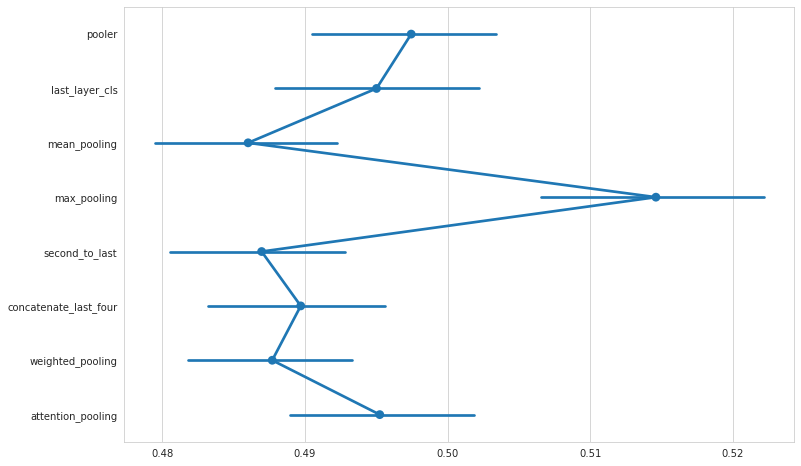

If you find any bugs in this notebook, please let me know. 

In [1]:
# Imports

import os
import numpy as np
import pandas as pd
import random

from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, SequentialSampler, RandomSampler, DataLoader

from tqdm.notebook import tqdm

import gc; gc.enable()
from IPython.display import clear_output

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
logging.set_verbosity_error()

In [2]:
# Definitions

INPUT_DIR = '../input/commonlitreadabilityprize'
MODEL_NAME = 'roberta-large'

HIDDEN_SIZE = 1024
NUM_HIDDEN_LAYERS = 24
LAYER_START = 4   # for WeightedLayerPoolingModel

HIDDEN_DIM_FC = 128    # for AttentionPooling

MAX_LENGTH = 300
LR = 2e-5
EPS = 1e-8

SEED = 42

NUM_FOLDS = 5
SEEDS = [113, 71, 17, 43, 37]

EPOCHS = 5
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 32

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Utilities

# Utility classes and functions

class ContinuousStratifiedKFold(StratifiedKFold):
    def split(selfself, x, y, groups=None):
        num_bins = int(np.floor(1 + np.log2(len(y))))
        bins = pd.cut(y, bins=num_bins, labels=False)
        return super().split(x, bins, groups)
    
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_data_loaders(data, fold):
    
    x_train = data.loc[data.fold != fold, 'excerpt'].tolist()
    y_train = data.loc[data.fold != fold, 'target'].values
    x_val = data.loc[data.fold == fold, 'excerpt'].tolist()
    y_val = data.loc[data.fold == fold, 'target'].values
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    encoded_train = tokenizer.batch_encode_plus(
        x_train, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        truncation=True,
        max_length=MAX_LENGTH, 
        return_tensors='pt'
    )
    
    encoded_val = tokenizer.batch_encode_plus(
        x_val, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        truncation=True,
        max_length=MAX_LENGTH, 
        return_tensors='pt'
    )
    
    dataset_train = TensorDataset(
        encoded_train['input_ids'],
        encoded_train['attention_mask'],
        torch.tensor(y_train)
    )
    dataset_val = TensorDataset(
        encoded_val['input_ids'],
        encoded_val['attention_mask'],
        torch.tensor(y_val)
    )
    
    dataloader_train = DataLoader(
        dataset_train,
        sampler = RandomSampler(dataset_train),
        batch_size=TRAIN_BATCH_SIZE
    )

    dataloader_val = DataLoader(
        dataset_val,
        sampler = SequentialSampler(dataset_val),
        batch_size=VAL_BATCH_SIZE
    )

    return dataloader_train, dataloader_val

<h2>Model definitions</h2>

In [4]:
# Model definitions

class PoolerModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'num_labels':1})
        self.model = AutoModel.from_pretrained(model_name, config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        pooler_output = outputs[1]
        logits = self.linear(pooler_output)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
        
class LastLayerCLSModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        cls_embeddings = last_hidden_state[:,0]
        logits = self.linear(cls_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
        
class MeanPoolingModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.linear(mean_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
        
class MaxPoolingModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        last_hidden_state[input_mask_expanded == 0] = -1e9   # large negative value
        max_embeddings, _ = torch.max(last_hidden_state, 1)
        logits = self.linear(max_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
        
class SecondToLastLayerCLSModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        second_to_last_layer = 23
        cls_embeddings = all_hidden_states[second_to_last_layer,:,0]
        logits = self.linear(cls_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
class ConcatenateLastFourModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(4*HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        concatenate_pooling = torch.cat(
            (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]), -1
        )
        concatenate_pooling = concatenate_pooling[:,0]
        logits = self.linear(concatenate_pooling)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
        
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average
    
class WeightedLayerPoolingModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.pooling = WeightedLayerPooling(NUM_HIDDEN_LAYERS, 
                                      layer_start=LAYER_START,
                                      layer_weights=None)
        self.layer_norm = nn.LayerNorm(HIDDEN_SIZE)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        
        weighted_pooling_embeddings = self.pooling(all_hidden_states)
        weighted_pooling_embeddings = weighted_pooling_embeddings[:,0]
        
        norm_embeddings = self.layer_norm(weighted_pooling_embeddings)
        logits = self.linear(norm_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
class AttentionPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_fc):
        super(AttentionPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_fc = hiddendim_fc
        self.dropout = nn.Dropout(0.1)

        q_t = np.random.normal(loc=0.0, scale=0.1, size=(1, self.hidden_size))
        self.q = nn.Parameter(torch.from_numpy(q_t)).float().to(DEVICE)
        w_ht = np.random.normal(loc=0.0, scale=0.1, size=(self.hidden_size, self.hiddendim_fc))
        self.w_h = nn.Parameter(torch.from_numpy(w_ht)).float().to(DEVICE)

    def forward(self, all_hidden_states):
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out = self.attention(hidden_states)
        out = self.dropout(out)
        return out

    def attention(self, h):
        v = torch.matmul(self.q, h.transpose(-2, -1)).squeeze(1)
        v = F.softmax(v, -1)
        v_temp = torch.matmul(v.unsqueeze(1), h).transpose(-2, -1)
        v = torch.matmul(self.w_h.transpose(1, 0), v_temp).squeeze(2)
        return v

class AttentionPoolingModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.pooler = AttentionPooling(NUM_HIDDEN_LAYERS, HIDDEN_SIZE, HIDDEN_DIM_FC)
        
        self.linear = nn.Linear(HIDDEN_DIM_FC, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        
        attention_pooling_embeddings = self.pooler(all_hidden_states)
        
        logits = self.linear(attention_pooling_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        

<h2>Read data and create folds</h2>

For the results to be reproducible, I create the same folds I'm using in the competition.

In [5]:
# Read competition data
data = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))

# Create stratified folds
kf = ContinuousStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for f, (t_, v_) in enumerate(kf.split(data, data.target)):
    data.loc[v_, 'fold'] = f
data['fold'] = data['fold'].astype(int)


<h2>Training and evaluation</h2>

In [6]:
def evaluate(model, val_dataloader):

    model.eval()
    
    loss_val_total = 0
    
    for batch in val_dataloader:
        
        batch = tuple(b.to(DEVICE) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            loss = model(**inputs)
            
        loss_val_total += loss.item()

    loss_val_avg = loss_val_total/len(val_dataloader) 
            
    return loss_val_avg


def train(model, train_dataloader, val_dataloader):
    
    optimizer = AdamW(model.parameters(), lr = LR, eps = EPS)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                                num_training_steps=len(train_dataloader) * EPOCHS)
    best_val_loss = 1
    model.train()
                                                
    for epoch in range(EPOCHS):
    
        loss_train_total = 0
        for batch in tqdm(train_dataloader):
    
            model.zero_grad()
            batch = tuple(b.to(DEVICE) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }
        
            loss = model(**inputs)
            loss_train_total += loss.item()
        
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        loss_train_avg = loss_train_total / len(train_dataloader)
        loss_val_avg = evaluate(model, val_dataloader)
        print(f'epoch:{epoch+1}/{EPOCHS} train loss={loss_train_avg}  val loss={loss_val_avg}')
   
        if loss_val_avg < best_val_loss:
            best_val_loss = loss_val_avg
            
    return best_val_loss

The process takes more than eight hours with Kaggle kernels, so I've included a termination condition for MAX_RUNS=2 runs (instead of the 5 seeds x 5 folds = 25 runs). Just remove it in both loops to run the full experiment.

In [7]:
# Main loop

losses = []

MAX_RUNS = 2
runs = 0   # Variable to control termination condition

for i, seed in enumerate(SEEDS):
       
    # Termination condition
    if runs == MAX_RUNS:
        print(f'{runs} runs termination condition reached.')
        break    
    
    print(f'********* seed({i}) = {seed} ***********')
    
    for fold in range(NUM_FOLDS):
        print(f'*** fold = {fold} ***')
        seed_everything(seed)
        train_dataloader, val_dataloader = get_data_loaders(data, fold)
        
        # Change the instantiated model by LastLayerCLSModel, PoolingModel, etc. 
        model = PoolerModel(MODEL_NAME)
        model.to(DEVICE)
        
        loss = train(model, train_dataloader, val_dataloader)
        losses.append(loss)
        
        del model
        gc.collect()
        
        # Termination condition
        runs += 1
        if runs == MAX_RUNS:
            break
    

********* seed(0) = 113 ***********
*** fold = 0 ***


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

  0%|          | 0/284 [00:00<?, ?it/s]

epoch:1/5 train loss=0.501669784142098  val loss=1.0456004805035062


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:2/5 train loss=0.2207454034901211  val loss=0.2563667479488585


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:3/5 train loss=0.0725503308226315  val loss=0.26245757192373276


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:4/5 train loss=0.020748161544783934  val loss=0.25851768338017994


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:5/5 train loss=0.005722257886844372  val loss=0.25742922971645993
*** fold = 1 ***


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:1/5 train loss=0.4344233691193898  val loss=0.3352832156750891


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:2/5 train loss=0.17613861505860384  val loss=0.27765414284335244


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:3/5 train loss=0.05939924555853612  val loss=0.2808803874585364


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:4/5 train loss=0.02080610659117745  val loss=0.2770214652021726


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:5/5 train loss=0.006143457030190457  val loss=0.2687056561311086
2 runs termination condition reached.


<h2>Results</h2>

In [8]:
# Save the losses (a column per model)

# Read the results of the previous models, if any
try:
    results = pd.read_csv('experiment-1.csv')
except:
    results = pd.DataFrame(data=None)
    
# Change the column with a name representative of the model: last_layer_cls, mean_pooling, etc.
results['pooler'] = losses
results.to_csv('experiment-1.csv', index=False)

<AxesSubplot:>

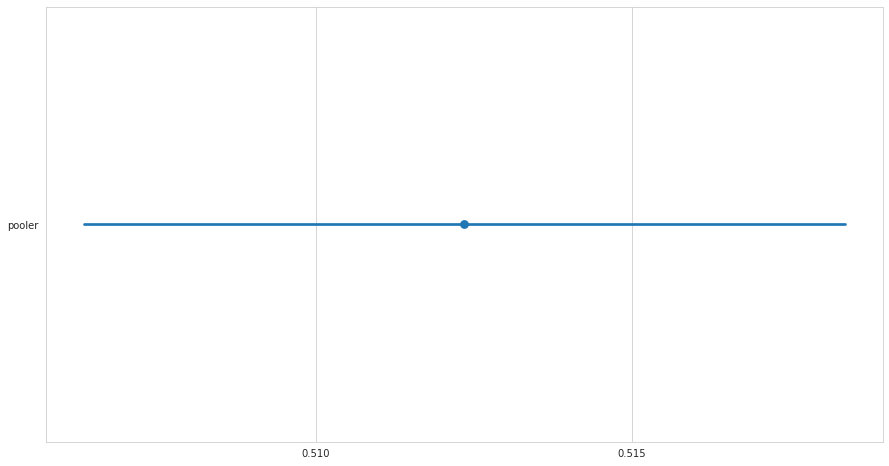

In [9]:
# Plot 95% confidence interval of the mean of the RMSE

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xticks(np.arange(0.45, 0.54, step=0.005))
ax.set_axis_on()
sns.pointplot(data=np.sqrt(results), ci=95, orient='h', ax=ax)